In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
dfData = pd.read_csv('ex2data2.txt', names = ['Test 1','Test 2','Accepted'])
dfTarget = dfData['Accepted'] 
dfData.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


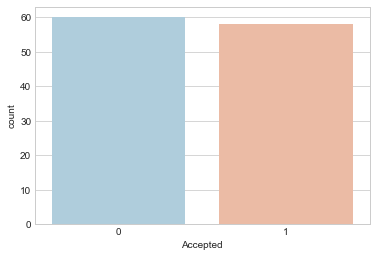

In [3]:
'''
Visualize data.
'''
sns.set_style('whitegrid')
sns.countplot(x = 'Accepted',data = dfData,palette='RdBu_r')

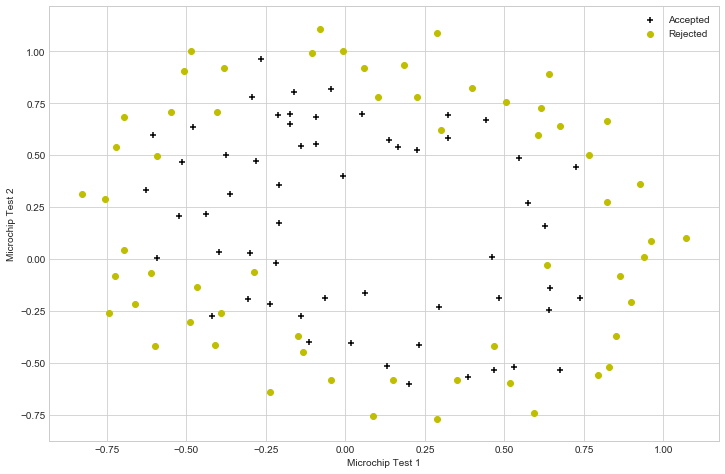

In [4]:
dfAccepted = dfData[dfData['Accepted']==1]
dfRejected = dfData[dfData['Accepted']==0]

fig,axes = plt.subplots(figsize = (12,8))
axes.scatter(dfAccepted['Test 1'],dfAccepted['Test 2'],c='k',marker = '+',label = 'Accepted')
axes.scatter(dfRejected['Test 1'],dfRejected['Test 2'],c ='y',label ='Rejected')
axes.set_xlabel('Microchip Test 1')
axes.set_ylabel('Microchip Test 2')
axes.legend()

In [5]:
def mapFeatures(x1,x2,degree,addBiasColumn = False):
    df = pd.DataFrame()
    if addBiasColumn:
        df['Bias'] = np.ones(len(x1))
    for i in range(1,degree+1):
        for j in range(0,i+1):
            df['x1^'+str((i-j))+' * x2^'+str(j)] = np.power(x1,i-j)*np.power(x2,j)
    return df

In [6]:
'''
Map the features into all polynomial terms of x1 and x2 up to the sixth power.
''' 
dfFeatures = mapFeatures(dfData['Test 1'],dfData['Test 2'],6, True)
dfFeatures.shape

(118, 28)

In [7]:
from scipy import optimize
class LogisticRegression:
    def __init__(self):
        pass
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))
    def getCost(self,theta,X,y,regFactor = 0):
        theta = np.matrix(theta)
        hypothesis = self.sigmoid(np.dot(X,theta.T))
        intNumSamples = X.shape[0]
        J = -(np.dot(y.T,(np.log(hypothesis))) + np.dot((1-y).T,np.log(1-hypothesis)))/intNumSamples
        '''
        Don't add theta0.
        '''
        R = np.sum(np.square(theta[1:,0]))*regFactor/2/intNumSamples
        J += R
        self.cost = np.array(J)
        return self.cost
    def getGrad(self,theta,X,y,regFactor = 0):
        theta = np.matrix(theta)
        intNumSamples = X.shape[0]
        hypothesis = self.sigmoid(np.dot(X,theta.T))
        error = hypothesis -y
        tempTheta =np.copy(theta)

        tempTheta[:,0] = 0
        '''
        Don't regularize theta0.
        '''
        grad =  np.dot(X.T,error)/intNumSamples + tempTheta.T*regFactor/intNumSamples
        self.grad = np.array(grad).ravel()
        return self.grad
    def optimizeTheta(self,theta,X,y,regFactor, optMethod = None):
        self.fmin = optimize.minimize(fun=self.getCost,x0=theta,method = optMethod,jac = self.getGrad,args=(X,y,regFactor))
        return self.fmin
    def predictAcceptance(self,theta,scores):
        return round(100*self.sigmoid(np.dot(scores,theta.T)),2)
    def getTrainAccuracy(self,theta,X,y,threshold):
        intNumSamples = X.shape[0]
        theta = np.matrix(theta)
        '''
        Calculate probability of being accepted.
        '''
        probabilities = self.sigmoid(np.dot(X,theta.T))
        correctPrediction = np.zeros((intNumSamples,1))
        for i in range(0,intNumSamples):
            if probabilities[i] >= threshold:
                '''
                Did the chip actually get accepted?
                '''
                if y[i] == 1: correctPrediction[i,0] = 1
            else:
                '''
                Did the chip actually get rejected?
                '''
                if y[i] ==0:correctPrediction[i,0] = 1
        self.probability = 100*correctPrediction.sum()/intNumSamples
        return round(self.probability,2)

In [8]:
X = np.matrix(dfFeatures)
y = np.matrix(dfTarget).T
lm = LogisticRegression()

In [9]:
'''
Testing.
'''
theta =np.zeros(X.shape[1])
regFactor = 1
lm.getCost(theta,X,y,regFactor)
lm.getGrad(theta,X,y,regFactor)
print(lm.cost)
print(lm.grad[:5])
'''
More testing.  With theta != 0 we can ensure that the regularized portion
of getCost and getGrad is doing what it's supposed to.
'''
theta =np.ones(X.shape[1])
regFactor = 10
lm.getCost(theta,X,y,regFactor)
lm.getGrad(theta,X,y,regFactor)
print(lm.cost)
print(lm.grad[:5])

[[0.69314718]]
[8.47457627e-03 1.87880932e-02 7.77711864e-05 5.03446395e-02
 1.15013308e-02]
[[2.02044154]]
[0.34604507 0.16135192 0.19479576 0.22686278 0.09218568]


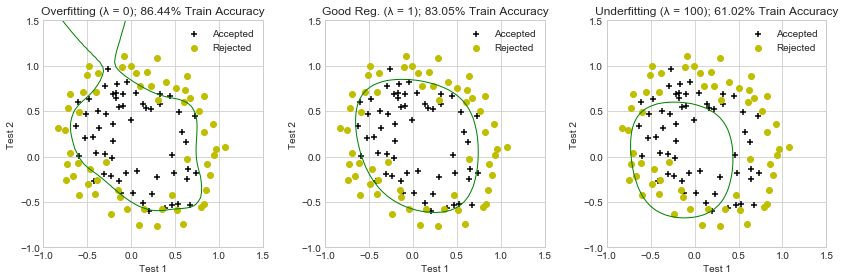

In [10]:
'''
Let's check out a few lambda values and see how they affect the training accuracy.
'''
regFactors = np.array([0,1,100])
strTitles = np.array(['Overfitting','Good Reg.','Underfitting'])
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (12,4))
'''
Here is the grid range.
'''
u = np.linspace(-1,1.5,50)
v = np.linspace(-1,1.5,50)
z = np.zeros((len(u),len(v)))
U, V = np.meshgrid(u,v)
for i in range(0,regFactors.shape[0]):
    theta = np.zeros(X.shape[1])
    regFactor = regFactors[i]
    '''
    Calculate minimum theta using SciPy's optimization library.
    '''
    fmin = lm.optimizeTheta(theta,X,y,regFactor, 'Newton-CG')
    '''
    Use minimum theta to make some predictions.
    '''
    theta = np.matrix(fmin['x'])
    '''
    How accurate is the model?
    '''
    trainAccuracy = lm.getTrainAccuracy(theta,X,y,0.5)
    axes[i].scatter(dfAccepted['Test 1'],dfAccepted['Test 2'],c='k',marker = '+',label = 'Accepted')
    axes[i].scatter(dfRejected['Test 1'],dfRejected['Test 2'],c ='y',label ='Rejected')
    axes[i].set_title('%s (λ = %s); %s%% Train Accuracy'%(strTitles[i],regFactor,trainAccuracy))
    axes[i].set_xlabel('Test 1')
    axes[i].set_ylabel('Test 2')
    axes[i].legend()
    '''
    Plot the boundary.
    '''
    for j in range(len(u)):
        for k in range(len(v)):
            boundaryFeatures = mapFeatures(np.array([u[j]]),np.array([v[k]]),6,True)
            z[j,k] = np.dot(boundaryFeatures,theta.T)
    '''
    Want z to be in [columns,rows] for .contour().
    '''
    z = z.T
    axes[i].contour(U,V,z,[0], linewidths = 1, colors = 'g')
plt.tight_layout()